In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import norm
import matplotlib.pyplot as plt

In [2]:
def categorical_summarized(dataframe, x=None, y=None, hue=None, palette='Set1', ax=None, order=None, verbose=True, figsize=None):
    if x == None:
        column_interested = y
    else:
        column_interested = x
    series = dataframe[column_interested]
    print(series.describe())
    print('mode: ', series.mode())
    if verbose:
        print('='*80)
        print(series.value_counts())
    
    if figsize:
        plt.figure(figsize=figsize)

    sns.countplot(x=x, y=y, hue=hue, data=dataframe,
                  palette=palette, order=order, ax=ax)
    plt.show()

In [3]:
def quantitative_summarized(dataframe, x=None, y=None, hue=None, palette='Set1', ax=None, order=None, verbose=True, swarm=False, figsize=None, title=None):
    series = dataframe[y]
    print(series.describe())
    print('mode: ', series.mode())
    if verbose:
        print('='*80)
        print(series.value_counts())
    
    if figsize:
        plt.figure(figsize=figsize)

    sns.boxplot(x=x, y=y, hue=hue, data=dataframe,
                palette=palette, order=order, ax=ax)

    if swarm:
        sns.swarmplot(x=x, y=y, hue=hue, data=dataframe,
                      palette=palette, order=order, ax=ax)
    
    if title:
        plt.title(title)

    plt.show()

# 0 Информация о датасете

Рассматриваем данные о убийствах в США за 2014 год.
- Из исходного датасета отбрасываем признаки, которые являются идентификаторами преступлений в базе данных: `Record ID`, `Agency Code`, `Agency Name`, `Incident`, `Record Source`.
- Отбрасываем дату регистрации преступления.
- Отбрасываем признаки, устанавливаемые в процессе раскрытия преступления: `Perpetrator Sex`, `Perpetrator Age`, `Perpetrator Race`, `Perpetrator Ethnicity`, `Relationship`

Оставляем только те признаки, которые известны на момент регистрации преступления:
- `Agency Type` - тип отделения полиции, где зарегистрировали преступления
- `State`, `City` - штат и город
- `Crime Type` - тип преступления
- `Victim Sex`, `Victim Age`, `Victim Race`, `Victim Ethnicity` - информация о жертве
- `Weapon` - тип оружия / причина смерти
- `Victim Count` - кол-во дополнительно пострадавших (0 - только жертва)
- `Perpetrator Count` - сколько людей действовали вместе с преступником (0 - преступник был один)

Целевая переменная - `Crime Solved` - раскрыто ли преступление (личность преступника установлена)

In [4]:
data = pd.read_csv('database.csv')
data = data[data.Year == 2014]

columns = ['Agency Type', 'State', 'City', 'Crime Type', 'Victim Sex', 'Victim Age', 'Victim Race', 'Victim Ethnicity', 'Weapon', 'Victim Count', 'Perpetrator Count', 'Crime Solved']
data = data[columns]
data['City'] = data['State'] + '_' + data['City']

/home/elfray/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# 1 Целевая переменная `Crime Solved`

Наблюдается дисбаланс по целевой переменной.

count     14331
unique        2
top         Yes
freq       9950
Name: Crime Solved, dtype: object
mode:  0    Yes
dtype: object
Yes    9950
No     4381
Name: Crime Solved, dtype: int64


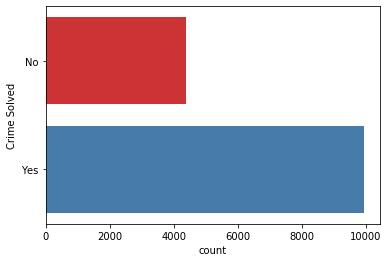

In [5]:
categorical_summarized(data, y = 'Crime Solved')

# 2 Категориальный признак `Agency Type`
Доля нераскрытых преступлений, зарегистрированных в муниципальной полииции, выше, чем у других типов полиции.

count                14331
unique                   7
top       Municipal Police
freq                 10943
Name: Agency Type, dtype: object
mode:  0    Municipal Police
dtype: object
Municipal Police    10943
Sheriff              2533
County Police         475
State Police          346
Special Police         28
Tribal Police           3
Regional Police         3
Name: Agency Type, dtype: int64


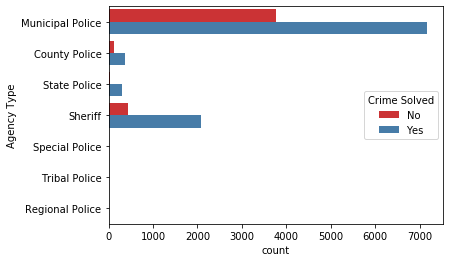

In [6]:
categorical_summarized(data, y='Agency Type', hue='Crime Solved')

# 3 Категориальный признак `City`

Наблюдается большое количество городов с малым количеством прецендентов в данных.

count                      14331
unique                      1400
top       California_Los Angeles
freq                         572
Name: City, dtype: object


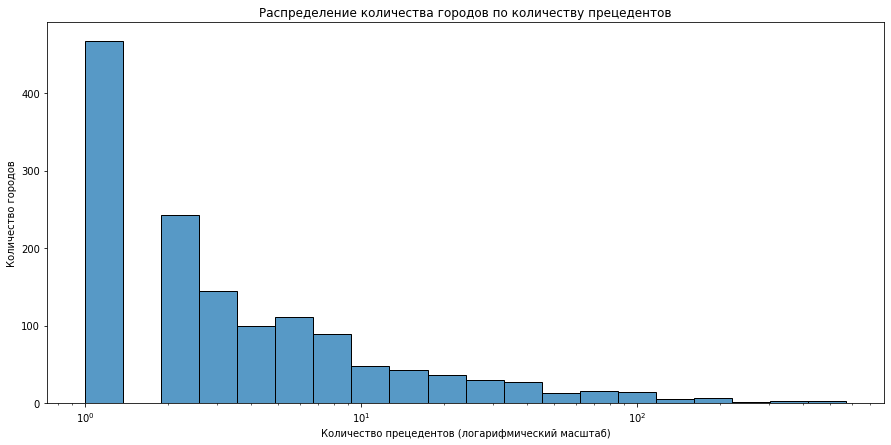

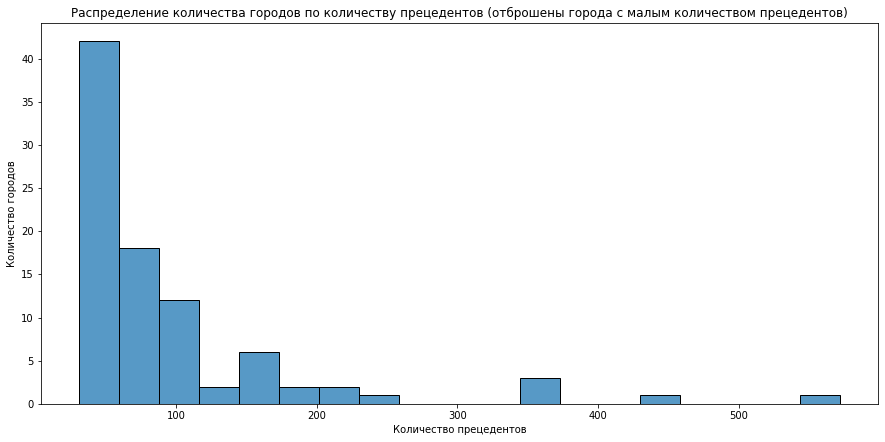

In [7]:
print(data.City.describe())

count_by_city = data.groupby('City').size().reset_index(name="count_by_city")
plt.figure(figsize=(15, 7))
sns.histplot(count_by_city.count_by_city, log_scale=True)
plt.xlabel('Количество прецедентов (логарифмический масштаб)')
plt.ylabel('Количество городов')
plt.title('Распределение количества городов по количеству прецедентов')
plt.show()

plt.figure(figsize=(15, 7))
sns.histplot(count_by_city[count_by_city.count_by_city > 30].count_by_city)
plt.xlabel('Количество прецедентов')
plt.ylabel('Количество городов')
plt.title('Распределение количества городов по количеству прецедентов (отброшены города с малым количеством прецедентов)')
plt.show()

# 4 Категориальный признак `State`

В данных есть штаты с малым количеством прецедентов. Также выделяются штаты `Illinois` и `District of Columbia`, где количество нераскрытых преступлений превышает количество раскрытых.

count          14331
unique            51
top       California
freq            1872
Name: State, dtype: object
mode:  0    California
dtype: object
California              1872
Texas                   1324
Florida                 1156
Pennsylvania             646
New York                 642
Georgia                  608
Michigan                 576
North Carolina           493
Illinois                 456
Ohio                     455
Louisiana                452
Missouri                 439
Tennessee                414
New Jersey               359
Virginia                 354
Maryland                 337
Indiana                  337
South Carolina           336
Arizona                  313
Washington               206
Oklahoma                 199
Nevada                   185
Mississippi              173
Wisconsin                171
Arkansas                 169
Kentucky                 168
Colorado                 165
Massachusetts            132
New Mexico               128
District of

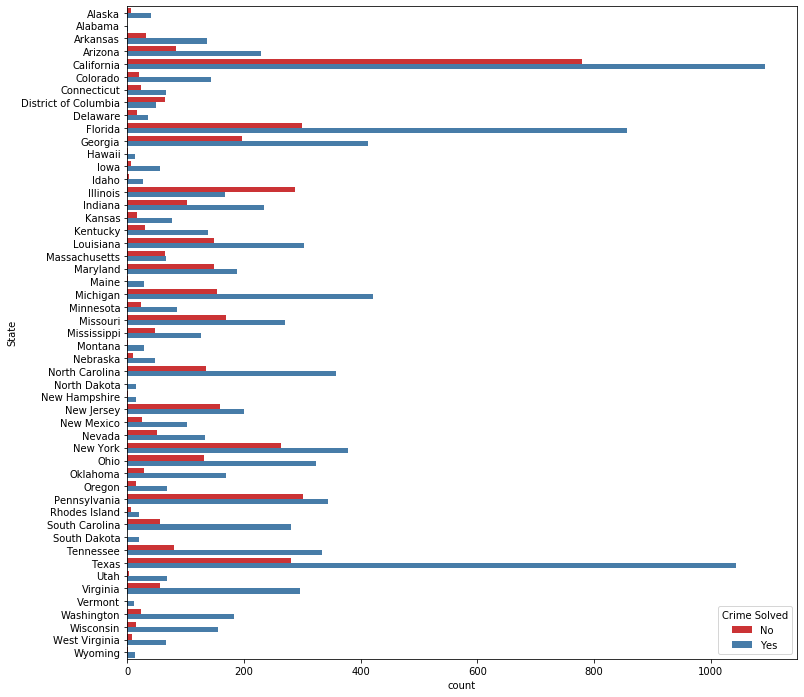

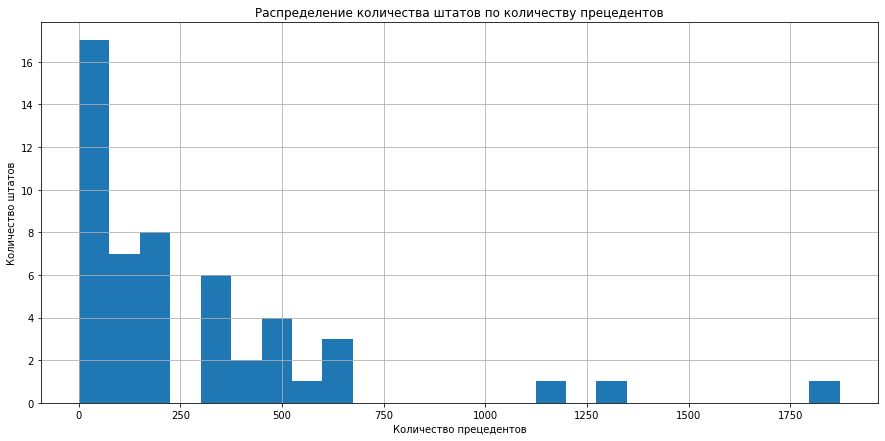

In [8]:
categorical_summarized(data, y='State', hue='Crime Solved', figsize=(12, 12))

count_by_state = data.groupby('State').size().reset_index(name='count_by_state')
count_by_state.hist(bins=25, figsize=(15, 7))
plt.xlabel('Количество прецедентов')
plt.ylabel('Количество штатов')
plt.title('Распределение количества штатов по количеству прецедентов')
plt.show()

# 5 Категориальный признак `Crime Type`

count                      14331
unique                         2
top       Murder or Manslaughter
freq                       14014
Name: Crime Type, dtype: object
mode:  0    Murder or Manslaughter
dtype: object
Murder or Manslaughter        14014
Manslaughter by Negligence      317
Name: Crime Type, dtype: int64


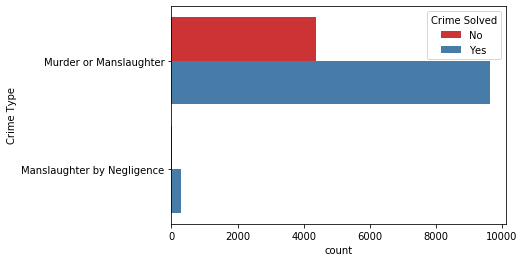

In [9]:
categorical_summarized(data, y='Crime Type', hue='Crime Solved')

# 6 Категориальный признак `Victim Sex`

Доля нераскрытых преступлений, в которых жертвой является женщина, меньше чем доля нераскрытых преступлений с жертвой - мужчиной.

count     14331
unique        3
top        Male
freq      11187
Name: Victim Sex, dtype: object
mode:  0    Male
dtype: object
Male       11187
Female      3108
Unknown       36
Name: Victim Sex, dtype: int64


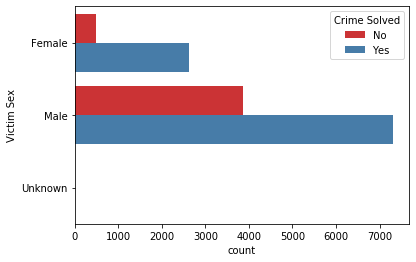

In [10]:
categorical_summarized(data, y='Victim Sex', hue='Crime Solved')

# 7 Категориальный признак `Victim Race`
Доля нераскрытых преступлений, в которых жертва - белый, меньше чем доля нераскрытых преступлений с жертвой - чернокожий.

count     14331
unique        5
top       Black
freq       7110
Name: Victim Race, dtype: object
mode:  0    Black
dtype: object
Black                            7110
White                            6701
Asian/Pacific Islander            233
Unknown                           174
Native American/Alaska Native     113
Name: Victim Race, dtype: int64


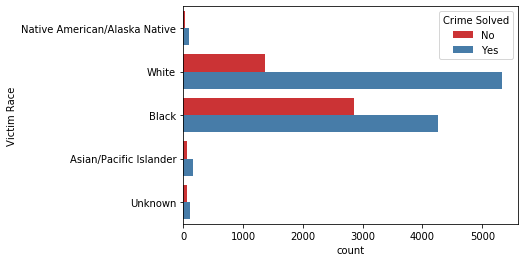

In [11]:
categorical_summarized(data, y='Victim Race', hue='Crime Solved')

# 8 Категориальный признак `Victim Ethnicity`

count       14331
unique          3
top       Unknown
freq         7587
Name: Victim Ethnicity, dtype: object
mode:  0    Unknown
dtype: object
Unknown         7587
Not Hispanic    4966
Hispanic        1778
Name: Victim Ethnicity, dtype: int64


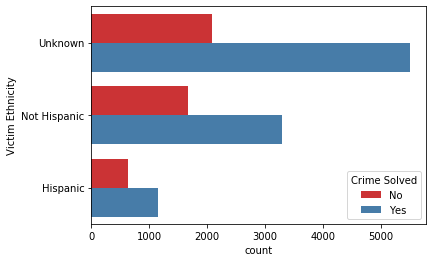

In [12]:
categorical_summarized(data, y='Victim Ethnicity', hue='Crime Solved')

# 9 Категориальный признак `Weapon`
Преступления, совершённые с использованием пистолетов и другого огнестрельного оружия, раскрыть сложнее всего.

count       14331
unique         16
top       Handgun
freq         6594
Name: Weapon, dtype: object
mode:  0    Handgun
dtype: object
Handgun          6594
Firearm          2526
Knife            1747
Blunt Object     1291
Unknown          1005
Rifle             350
Shotgun           305
Suffocation       106
Gun               100
Drugs              95
Strangulation      91
Fire               80
Drowning           20
Poison             10
Explosives          8
Fall                3
Name: Weapon, dtype: int64


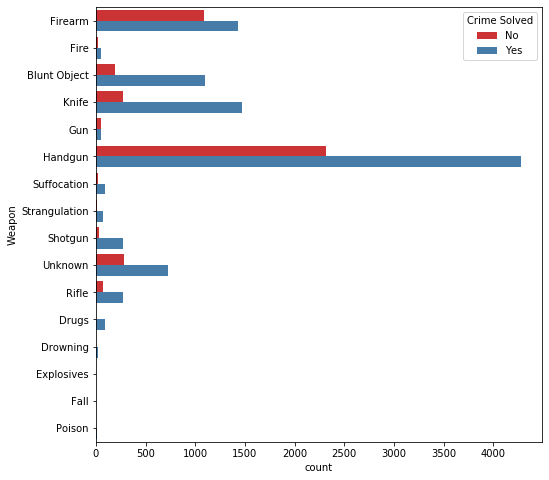

In [13]:
categorical_summarized(data, y='Weapon', hue='Crime Solved', figsize=(8, 8))

# 9 Вещественная переменная признак `Victim Age`
На диаграмме видны выбросы со значениями больше 100 лет. Такие значения можно трактовать как ошибки ввода или пропущенные значения.

count    14331.000000
mean        41.013816
std         84.656748
min          0.000000
25%         22.000000
50%         31.000000
75%         44.000000
max        998.000000
Name: Victim Age, dtype: float64
mode:  0    22
dtype: int64
22    550
23    531
21    511
24    501
20    494
     ... 
93      5
96      4
97      4
99      2
94      2
Name: Victim Age, Length: 99, dtype: int64


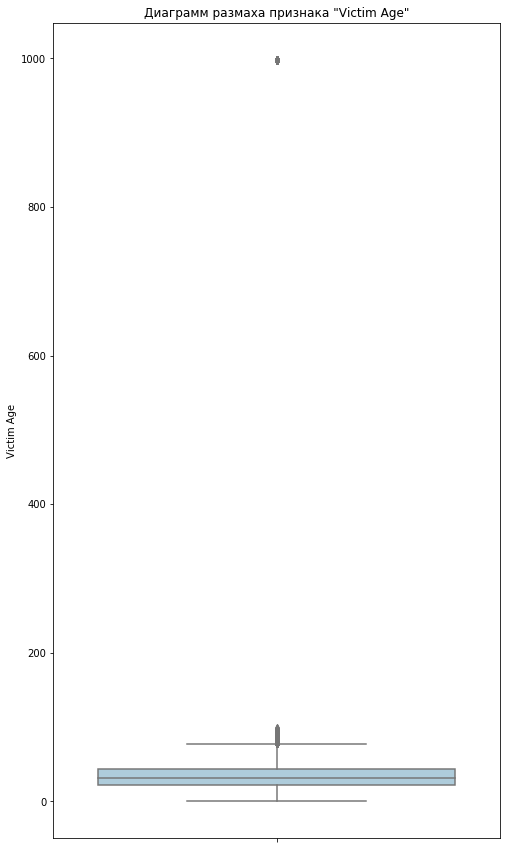

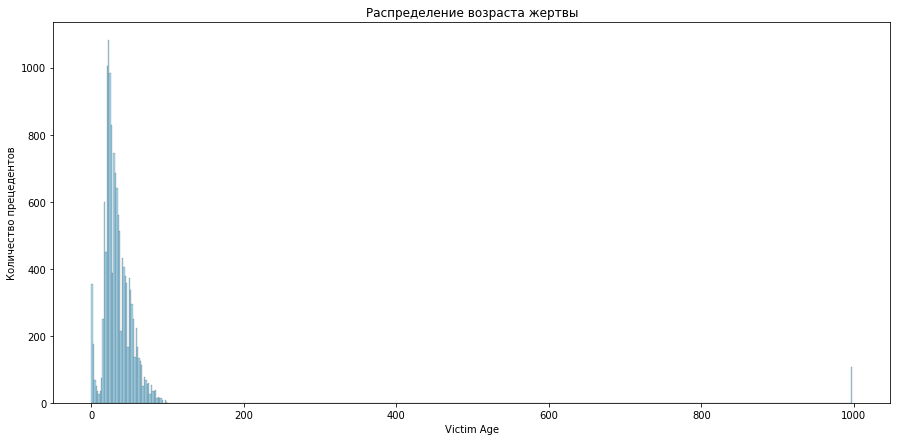

In [14]:
quantitative_summarized(data, y='Victim Age', figsize=(8, 15), title='Диаграмм размаха признака "Victim Age"', palette='Paired')

plt.figure(figsize=(15, 7))
sns.histplot(data['Victim Age'], color='skyblue')
plt.xlabel('Victim Age')
plt.ylabel('Количество прецедентов')
plt.title('Распределение возраста жертвы')
plt.show()

<br>
Также наблюдается аномальный рост количества жертв с возрастом меньше 10 лет. Это можно объяснить ошибкой ввода возраста в учётные системы.

count    14224.000000
mean        33.814890
std         16.706156
min          0.000000
25%         22.000000
50%         30.000000
75%         44.000000
max         99.000000
Name: Victim Age, dtype: float64
mode:  0    22
dtype: int64
22    550
23    531
21    511
24    501
20    494
     ... 
93      5
96      4
97      4
99      2
94      2
Name: Victim Age, Length: 98, dtype: int64


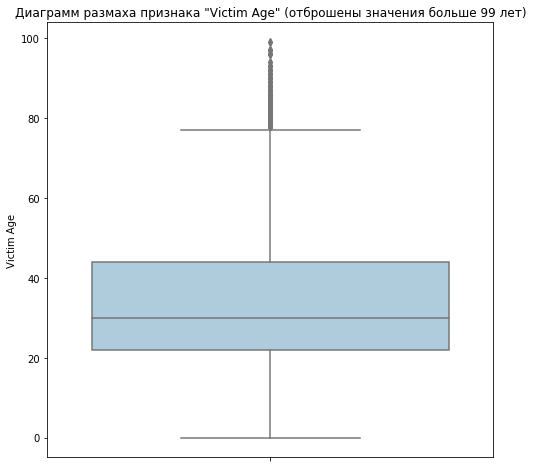

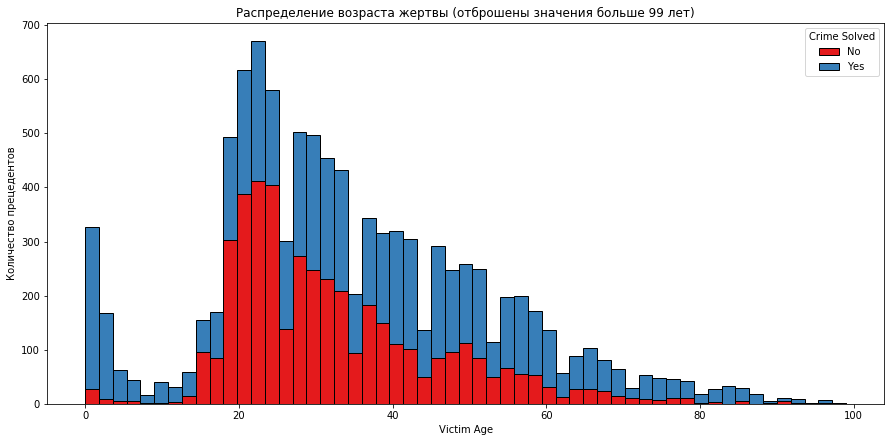

In [15]:
data_cleaned = data[data['Victim Age'] < 100]

quantitative_summarized(data_cleaned, y='Victim Age', figsize=(8, 8), title='Диаграмм размаха признака "Victim Age" (отброшены значения больше 99 лет)', palette='Paired')

plt.figure(figsize=(15, 7))
sns.histplot(data=data_cleaned, x='Victim Age', hue='Crime Solved', palette='Set1', alpha=1)
plt.xlabel('Victim Age')
plt.ylabel('Количество прецедентов')
plt.title('Распределение возраста жертвы (отброшены значения больше 99 лет)')
plt.show()

count    13541.000000
mean        35.410162
std         15.488233
min         10.000000
25%         23.000000
50%         31.000000
75%         45.000000
max         99.000000
Name: Victim Age, dtype: float64
mode:  0    22
dtype: int64
22    550
23    531
21    511
24    501
20    494
     ... 
93      5
96      4
97      4
99      2
94      2
Name: Victim Age, Length: 88, dtype: int64


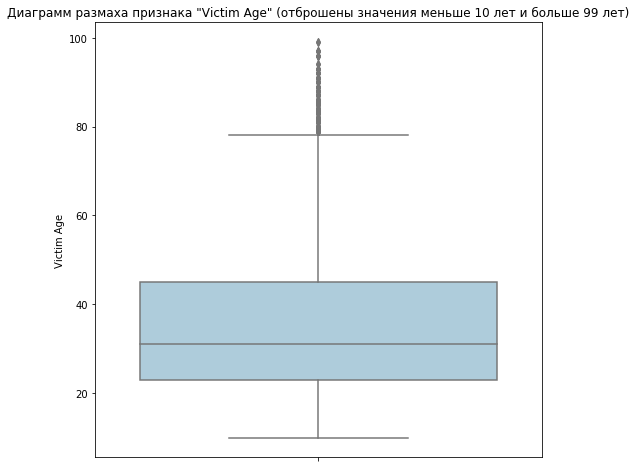

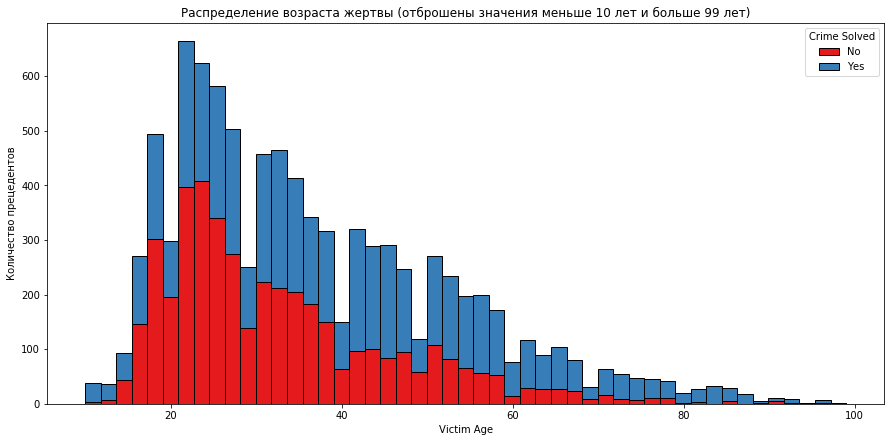

In [16]:
data_cleaned = data_cleaned[data_cleaned['Victim Age'] > 9]

quantitative_summarized(data_cleaned, y='Victim Age', figsize=(8, 8), title='Диаграмм размаха признака "Victim Age" (отброшены значения меньше 10 лет и больше 99 лет)', palette='Paired')

plt.figure(figsize=(15, 7))
sns.histplot(data=data_cleaned, x='Victim Age', hue='Crime Solved', palette='Set1', alpha=1)
plt.xlabel('Victim Age')
plt.ylabel('Количество прецедентов')
plt.title('Распределение возраста жертвы (отброшены значения меньше 10 лет и больше 99 лет)')
plt.show()

# 10 Вещественный признак `Victim Count`
В большинстве случаев жертва - единственный пострадавший.

count    14331.000000
mean         0.144093
std          0.582930
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          9.000000
Name: Victim Count, dtype: float64
mode:  0    0
dtype: int64
0    13004
1      955
2      204
3       88
5       30
4       25
9       10
7        8
6        7
Name: Victim Count, dtype: int64


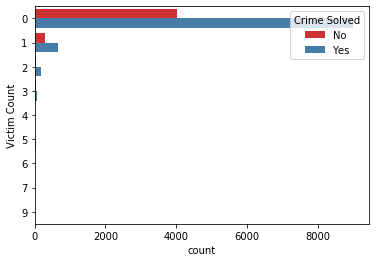

In [17]:
categorical_summarized(data, y='Victim Count', hue='Crime Solved')

# 11 Вещественный признак `Perpetrator Count`
Можно заметить, что в случае, когда преступник действовал не один, доля нераскрытых преступлений меньше, чем когда преступник действовал в одиночку.

count    14331.000000
mean         0.243179
std          0.707724
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         10.000000
Name: Perpetrator Count, dtype: float64
mode:  0    0
dtype: int64
0     12173
1      1360
2       468
3       228
4        56
5        26
6         9
10        4
9         4
7         3
Name: Perpetrator Count, dtype: int64


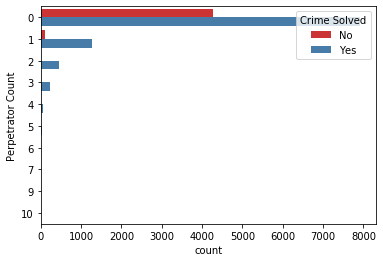

In [18]:
categorical_summarized(data, y='Perpetrator Count', hue='Crime Solved')

# 12 Подготовка данных
В рамках штатов заведём специальные категории, в которые объединим города с малым количеством прецедентов.

In [19]:
data = pd.read_csv('database.csv')
data = data[data.Year == 2014]

/home/elfray/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [20]:
MIN_COUNT = 60

count_by_state_city = pd.DataFrame(data.groupby(['State', 'City']).size().reset_index(name = "group_count"))
cities_big_stats = {(state, city) for state, city in count_by_state_city[count_by_state_city.group_count > MIN_COUNT][['State', 'City']].to_records(index=False)}
cities_small_stats = count_by_state_city[count_by_state_city.group_count <= MIN_COUNT]
states_stats = pd.DataFrame(cities_small_stats.groupby('State').agg('group_count').sum().reset_index(name = "group_count"))
states_big_stats = set(list(states_stats[states_stats.group_count > MIN_COUNT].State))
states_small_stats = set(list(states_stats[states_stats.group_count <= MIN_COUNT].State))

In [21]:
data['small_stats'] = True
for row in data.itertuples():
    if (row.State, row.City) in cities_big_stats:
        data.at[row.Index, 'small_stats'] = False
        continue
    
    if row.State in states_big_stats:
        data.at[row.Index, 'City'] = f"{row.State}_othercity"
        data.at[row.Index, 'small_stats'] = False
        continue

data = data[~data.small_stats]

Будем рассматривать значения `Victim Age` меньше 10 лет и больше 99 лет как пропущенные значения.

In [22]:
data['is_victim_age_missing'] = (data['Victim Age'] < 10) | (data['Victim Age'] > 99)

Балансируем выборку путём сокращения данных мажоритарного класса.

In [23]:
data_solved = data[data['Crime Solved'] == 'Yes']
data_not_solved = data[data['Crime Solved'] == 'No']

data_solved_undersample = data_solved.sample(n=data_not_solved.shape[0])

In [24]:
result_columns = columns + ['is_victim_age_missing']
result = pd.concat([data_solved_undersample[result_columns], data_not_solved[result_columns]], ignore_index=True).sample(frac=1).reset_index(drop=True)

Сохраняем предобработанные данные

In [25]:
result.to_csv('data_2014.csv', index=False)